In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import glm
import statsmodels.api as sm
from pygam import PoissonGAM, s

In [28]:
# Load dataset
df = pd.read_csv("PHILIPPINES_DATA_19.csv")

df = df.replace([" ", "NA", "NaN", "nan"], np.nan).dropna()
df['CR7'] = pd.to_numeric(df['CR7'], errors='coerce')
df.info

<bound method DataFrame.info of           FinalWgt  CR1  CR2  PHR3  PHR4  PHR5  CR5  CR6  CR7  CR8  ...  CR42  \
2      1001.339285  5.0  2.0   4.0   1.0   3.0  2.0  1.0  1.0  1.0  ...   3.0   
3      1001.339285  5.0  2.0   4.0   1.0   3.0  2.0  1.0  1.0  1.0  ...   2.0   
4      1001.339285  5.0  2.0   4.0   1.0   3.0  2.0  1.0  1.0  1.0  ...   3.0   
5      1001.339285  5.0  2.0   4.0   1.0   4.0  2.0  1.0  1.0  1.0  ...   3.0   
6      1001.339285  5.0  2.0   4.0   1.0   4.0  2.0  1.0  1.0  1.0  ...   3.0   
...            ...  ...  ...   ...   ...   ...  ...  ...  ...  ...  ...   ...   
10594   484.053855  2.0  1.0   1.0   2.0   3.0  2.0  1.0  1.0  1.0  ...   3.0   
10596   484.053855  3.0  1.0   1.0   2.0   3.0  2.0  1.0  1.0  1.0  ...   2.0   
10597   484.053855  3.0  1.0   1.0   2.0   4.0  2.0  1.0  1.0  1.0  ...   3.0   
10599   484.053855  3.0  1.0   1.0   2.0   4.0  2.0  1.0  1.0  1.0  ...   2.0   
10600   484.053855  3.0  1.0   1.0   2.0   4.0  2.0  1.0  1.0  1.0  ...   1.0

In [40]:
# Smoking status: 1 = Non-smoker, 2–7 = Smoker
df['smoker_status'] = np.where(df['CR7'] > 1, 1, 0)
df['smoker_status']

2        0
3        0
4        0
5        0
6        0
        ..
10594    0
10596    0
10597    0
10599    0
10600    0
Name: smoker_status, Length: 6614, dtype: int64

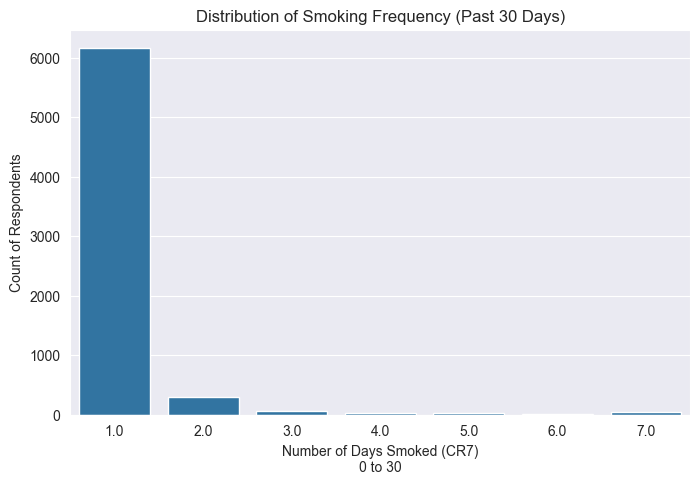

In [22]:
plt.figure(figsize=(8,5))
sns.countplot(x='CR7', data=df)
plt.title('Distribution of Smoking Frequency (Past 30 Days)')
plt.xlabel('Number of Days Smoked (CR7)\n0 to 30')
plt.ylabel('Count of Respondents')
plt.show()

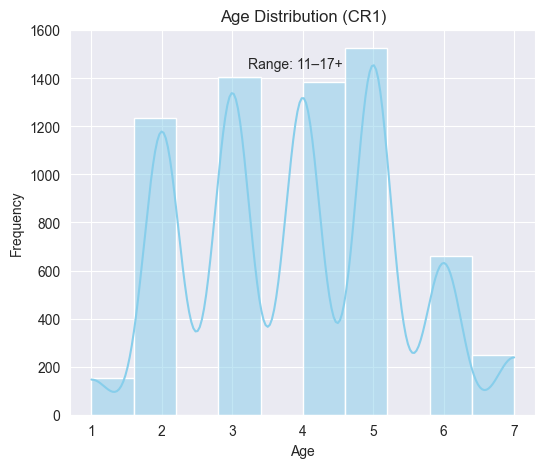

In [23]:
plt.figure(figsize=(6,5))
sns.histplot(df['CR1'], bins=10, kde=True, color='skyblue')
plt.title('Age Distribution (CR1)')
plt.xlabel('Age')
plt.xticks(ticks=range(int(df['CR1'].min()), int(df['CR1'].max()) + 1))
plt.ylabel('Frequency')
plt.text(df['CR1'].mean(), plt.ylim()[1]*0.9, 'Range: 11–17+', ha='center')
plt.show()

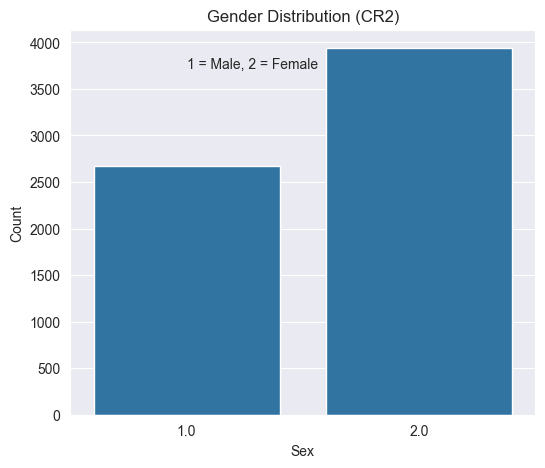

In [24]:
plt.figure(figsize=(6,5))
sns.countplot(x='CR2', data=df)
plt.title('Gender Distribution (CR2)')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.text(0, plt.ylim()[1]*0.9, '1 = Male, 2 = Female', ha='left')
plt.show()

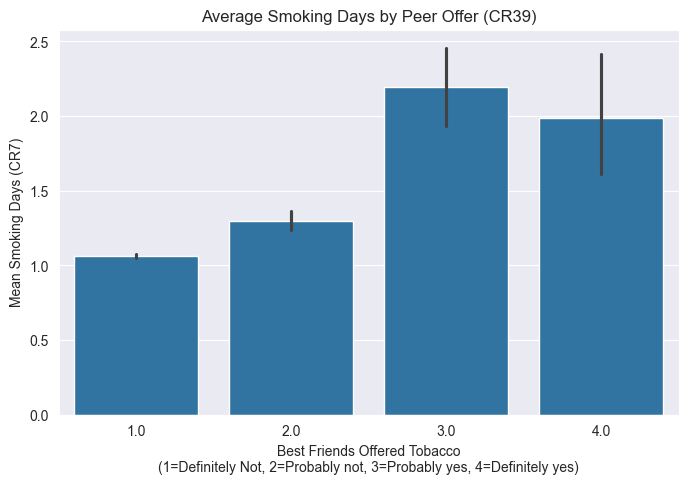

In [25]:
plt.figure(figsize=(8,5))
sns.barplot(x='CR39', y='CR7', data=df, estimator=np.mean)
plt.title('Average Smoking Days by Peer Offer (CR39)')
plt.xlabel('Best Friends Offered Tobacco\n'
           '(1=Definitely Not, 2=Probably not, 3=Probably yes, 4=Definitely yes)')
plt.ylabel('Mean Smoking Days (CR7)')
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    CR7   No. Observations:                 6614
Model:                            GLM   Df Residuals:                     6603
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7165.2
Date:                Fri, 24 Oct 2025   Deviance:                       711.46
Time:                        15:37:42   Pearson chi2:                     886.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08219
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1612      0.136      8.513      0.0

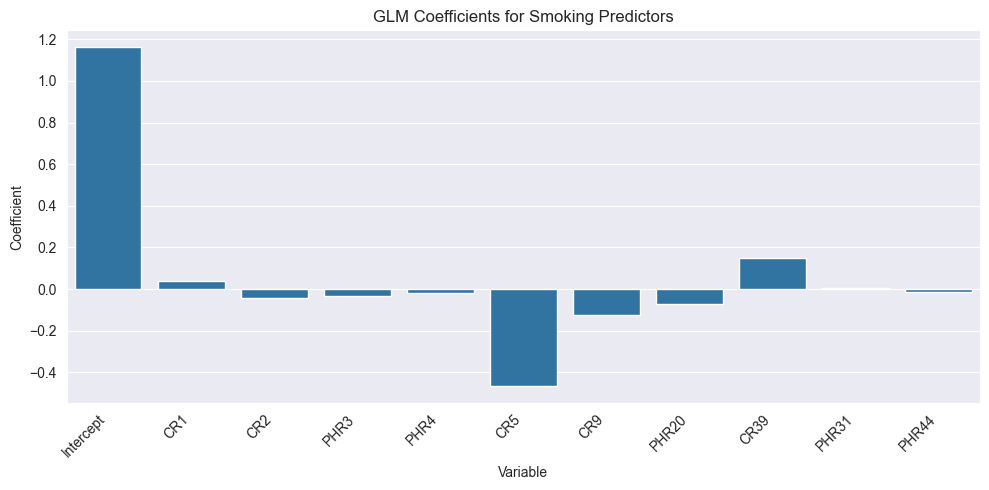

In [29]:
formula = 'CR7 ~ CR1 + CR2 + PHR3 + PHR4 + CR5 + CR9 + PHR20 + CR39 + PHR31 + PHR44'
glm_model = glm(formula=formula, data=df, family=sm.families.Poisson()).fit()
print(glm_model.summary())

# --- Coefficient Bar Chart ---
coef_df = glm_model.params.reset_index()
coef_df.columns = ['Variable', 'Coefficient']
plt.figure(figsize=(10,5))
sns.barplot(data=coef_df, x='Variable', y='Coefficient')
plt.xticks(rotation=45, ha='right')
plt.title('GLM Coefficients for Smoking Predictors')
plt.tight_layout()
plt.show()

C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\pygam\pygam.py:2858: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = y.ravel()


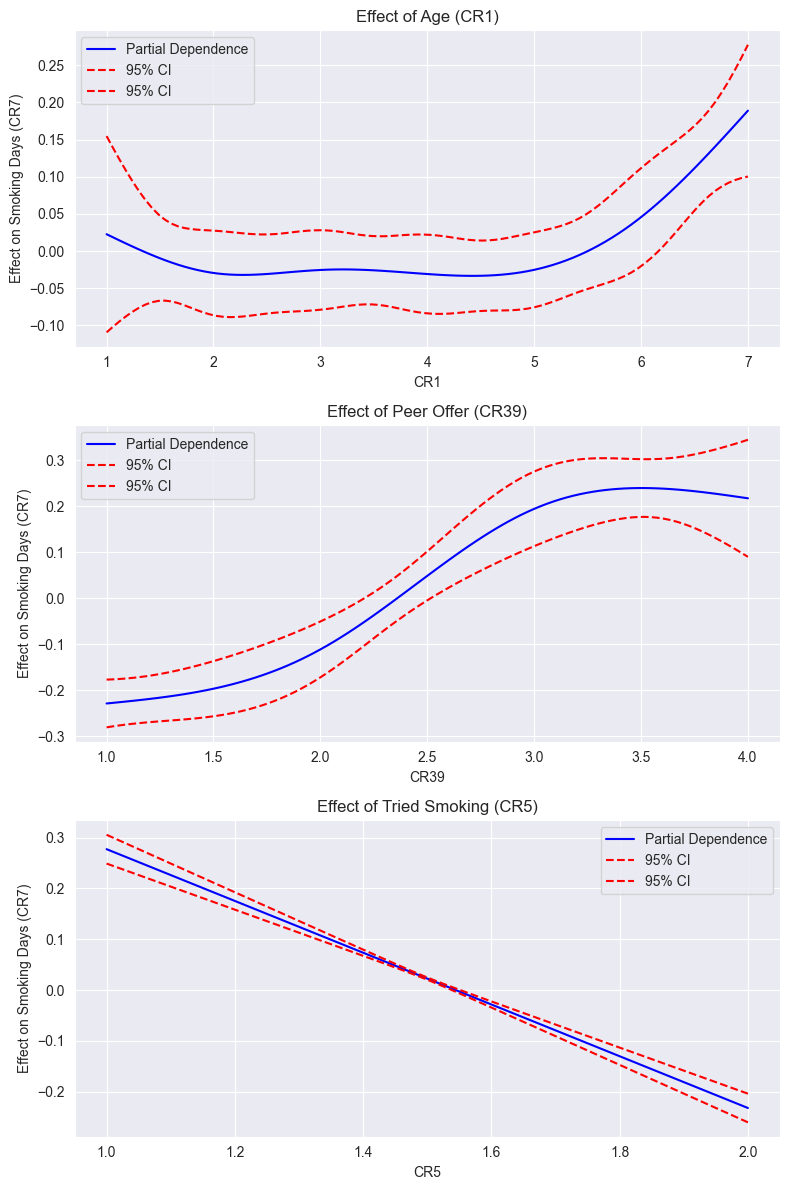

In [41]:
X = df[['CR1', 'CR39', 'CR5']].apply(pd.to_numeric, errors='coerce')
y = df['CR7']

# Fit the Poisson GAM model
gam = PoissonGAM(s(0) + s(1) + s(2)).fit(X, y)

# Prepare figure with vertical layout (3 rows, 1 column)
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Titles for each subplot
titles = [
    'Effect of Age (CR1)',
    'Effect of Peer Offer (CR39)',
    'Effect of Tried Smoking (CR5)'
]

# Generate and plot partial dependence for each predictor
for i, ax in enumerate(axs):
    # Generate X grid for smoother curve
    XX = gam.generate_X_grid(term=i)

    # Main smooth effect
    ax.plot(XX[:, i],
            gam.partial_dependence(term=i, X=XX),
            color='blue',
            label='Partial Dependence')

    # 95% confidence interval (dashed red line)
    ax.plot(XX[:, i],
            gam.partial_dependence(term=i, X=XX, width=0.95)[1],
            color='red',
            linestyle='--',
            label='95% CI')

    # Set titles and labels
    ax.set_title(titles[i], fontsize=12)
    ax.set_xlabel(X.columns[i])
    ax.set_ylabel('Effect on Smoking Days (CR7)')
    ax.legend()

# Adjust spacing for clarity
plt.tight_layout()

# Display the vertically stacked plots
plt.show()

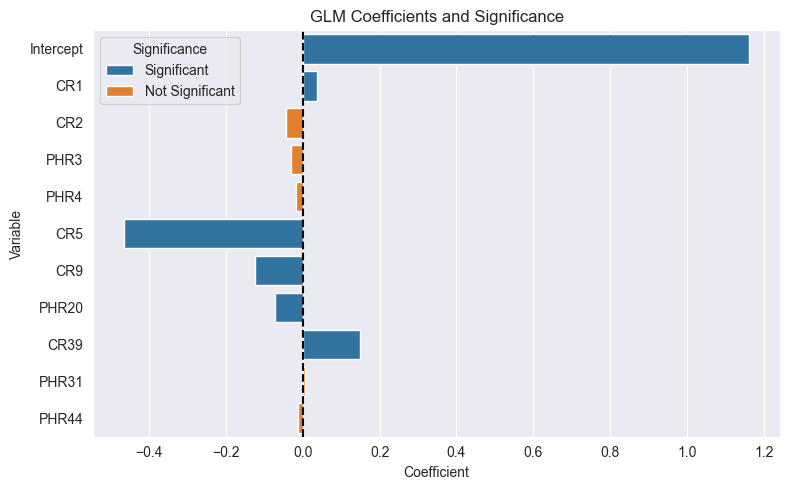

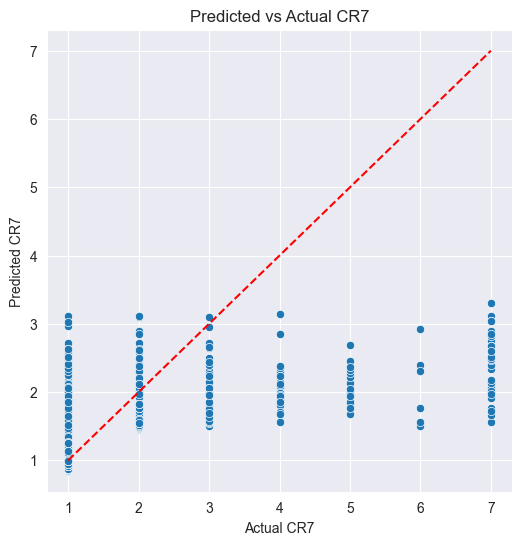

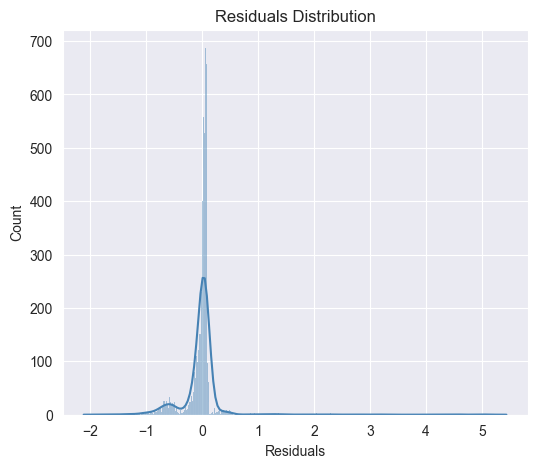

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'glm_result' is your fitted model object

# 1️⃣ Coefficient Plot
coef_df = pd.DataFrame({
    'Variable': glm_model.params.index,
    'Coefficient': glm_model.params.values,
    'P>|z|': glm_model.pvalues
})
coef_df['Significance'] = coef_df['P>|z|'].apply(lambda p: 'Significant' if p < 0.05 else 'Not Significant')

plt.figure(figsize=(8,5))
sns.barplot(x='Coefficient', y='Variable', data=coef_df, hue='Significance', dodge=False)
plt.title('GLM Coefficients and Significance')
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

# 2️⃣ Predicted vs Actual
df['Predicted_CR7'] = glm_model.predict(df)
plt.figure(figsize=(6,6))
sns.scatterplot(x=df['CR7'], y=df['Predicted_CR7'])
plt.plot([df['CR7'].min(), df['CR7'].max()], [df['CR7'].min(), df['CR7'].max()], 'r--')
plt.title('Predicted vs Actual CR7')
plt.xlabel('Actual CR7')
plt.ylabel('Predicted CR7')
plt.show()

# 3️⃣ Residuals Distribution
residuals = df['CR7'] - df['Predicted_CR7']
plt.figure(figsize=(6,5))
sns.histplot(residuals, kde=True, color='steelblue')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.show()
